In [166]:
import torch as t
%pip install transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer # pip install transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import time
import numpy as np
import sklearn
import pickle
import re # regular expressions, useful for decoding the output

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [167]:
def create_dataset(i_start=0, i_end=50, operation=t.add):
  """(1 pt) Create a dataset of pairs of numbers to calculate an operation
  on.
  DO NOT USE A FOR LOOP. Use pytorch functions, possibilities include
  meshgrid, stack, reshape, repeat, tile.
  (Note you'll have to use for loops on string stuff in other functions)
  The dataset should be a tuple of two tensors, X and y, where X is a Nx2
  tensor of numbers to add,
  and y is a N tensor of the correct answers.
  E.g., if i_start=0, i_end=2, then X should be
  tensor([[0,0,1,1],[0,1,0,1]]).T and y should be tensor([0,1,1,2]).
  I recommend doing all pairs of sums involving 0-49, but you may modify
  this.
  """
  # TODO
  indices = t.arange(i_end)
  i, j = t.meshgrid(indices, indices)
  # X = t.cat([i,j])
  # y = operation(X[:, 0], X[:, 1])
  # print(X, y)
  X = t.stack([i.reshape(-1), j.reshape(-1)], dim=1)
  y = operation(X[:, 0], X[:, 1])
  return X, y

In [168]:
# EleutherAI/gpt-neo-2.7B
def load_LLM(default="gpt2-large", device='cpu'):
  """(1 pt) Load a pretrained LLM and put on device. Default choice is a
  large-ish GPT-neo-2.7B model on Huggingface.
  Could also consider the "open GPT" from facebook: "facebook/opt-2.7b", or
  others
  here: https://huggingface.co/models?pipeline_tag=text-generation
  Explicitly load model and tokenizer, don't use the huggingface "pipeline"
  which hides details of the model
  (and it also has no batch processing, which we need here)
  """
  # TODO
  tokenizer = GPT2Tokenizer.from_pretrained(default) #AutoTokenizer.from_pretrained(default)
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})
  tokenizer.pad_token = '[PAD]'
  tokenizer.add_special_tokens({'eos_token': '[EOS]'})
  model = GPT2LMHeadModel.from_pretrained('gpt2-large') #AutoModelForCausalLM.from_pretrained(default, pad_token_id=tokenizer.eos_token_id)
  model.to(device)
  return model, tokenizer

In [169]:
def encode_problems(X, strategy='baseline', operation=t.add):
  """(1 pts) Encode the problems as strings. For example, if X is
  [[0,0,1,1],[0,1,0,1]],
  then the baseline output should be ["0+0=", "0+1=", "1+0=", "1+1="]"""
  output_strings = []
  op1 = " error "
  op2 = " error "
  if (operation==t.add):
    op1="+"
    op2=" plus "
    op3="6+3=9, 27+3=30, 35+27=62, "
  else:
    op1="*"
    op2=" multiplied by "
    op3="6*3=18, 13*3=39, 43*37=1591, "
  

  for xi in X:
    if strategy == 'baseline':
      # TODO: 
      # print(xi)
      encode_string = str(xi[0].item())+op1+str(xi[1].item())+"="
    elif strategy == 'alphabetical':
      # TODO: 
      encode_string = encode_string = str(xi[0].item())+op2+str(xi[1].item())+" equals "
    elif strategy == 'inferred':
      # TODO: 
      encode_string = op3+str(xi[0].item())+"+"+str(xi[1].item())+"="
    
    output_strings.append(encode_string)
  return output_strings

In [170]:
def generate_text(model, tokenizer, input_strings, verbose=True, device='cpu'):
    
    model.to(device)
    outputs = []
    t0 = time.time()
    with t.no_grad():
      for input_string in input_strings:
          input_ids = tokenizer.encode(input_string, return_tensors='pt').to(device)
          attention_mask = t.ones(input_ids.shape, dtype=t.long, device=device)
          pad_token_id = tokenizer.eos_token_id
          with t.no_grad():
              output = model.generate(
                  input_ids=input_ids,
                  attention_mask=attention_mask,
                  pad_token_id=pad_token_id,
                  max_new_tokens=2,
                  do_sample=True,
                  num_beams=2,
                  temperature=0.9
              )[0]
          outputs.append(tokenizer.decode(output, skip_special_tokens=True)) #
          if(verbose):
            print("\nInput: ",input_string)
            print("\nOutput: " + tokenizer.decode(output, skip_special_tokens=True))
    print("Time to generate text: ", time.time() - t0) # It took 4 minutes to do 25000 prompts on an NVIDIA 1080Ti.
    return outputs



In [171]:

def decode_output(output_strings, strategy='baseline', verbose=True):
  """(1 pt) Decode the output strings into a list of integers. Use "t.nan"
  for failed responses.
  One suggestion is to split on non-numeric characters, then convert to int.
  And use try/except to catch errors.
  """
  y_hat = []
  for s in output_strings:
    # TODO: y = f(s)
    y = re.findall(r'\d+(?:\.\d+)?', s)
    if(verbose):
      print("Predicted String: "+s+"\n")
      print("Decoded List of Numbers: ",y,"\n")
    if(len(y)>0):
      y_hat.append(int(y[0]))
    else:
      y_hat.append(-1)
  return y_hat

In [172]:
classes = []
import matplotlib.pyplot as plt

def analyze_results(X, y, y_hats, strategies):
  """(3 pts) Analyze the results.
  Output the accuracy of each strategy.
  Plot a scatter plot of the problems “x1+x2” with x1,x2 on each axis,
  and different plot markers to indicate whether the answer from your LLM was
  correct.
  (See write-up instructions for requirements on plots)
  Train a classifier to predict whether the LLM gave the correct response
  (using scikit-learn, for example)
  and plot the classifier boundary over the scatter plot with “contour”. (Use
  whatever classifier looks appropriate)"""
  # TODO
  count=0
  for i,j in zip(y_hats, y):
    j=j.item()
    if(i==j):
      count+=1
      classes.append(1)
    else:
      classes.append(0)

  x, y = X[:, 0], X[:, 1]
  plt.scatter(x, y, c=classes)

  plt.xlabel('X values')
  plt.ylabel('Y values')
  plt.title('Scatter Plot with Classes')

  plt.show()

  print("Accuracy: ", count/len(y_hats)*100, "%")
    

In [173]:
if __name__ == "__main__":
  device = t.device("cuda" if t.cuda.is_available() else "cpu") # Use GPU if available
  device = t.device('mps') if t.backends.mps.is_available() else device # Use Apple's Metal backend if available
  X, y = create_dataset(0, 50, operation=t.add)
  model, tokenizer = load_LLM(device=device)
  y_hats = [] # list of lists of predicted answers, y_hat, for each strategy
  strategies = ['baseline']#, 'inferred']
  

Time to generate text:  232.77062678337097


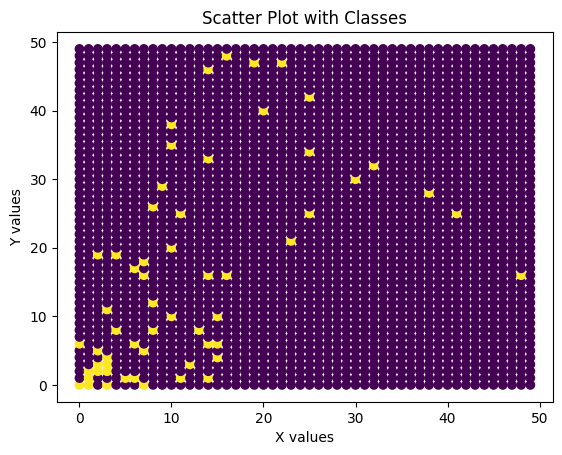

Accuracy:  2.32 %


In [174]:
for strategy in strategies:
    input_strings = encode_problems(X, strategy=strategy, operation=t.add)
    output_strings = generate_text(model, tokenizer, input_strings, verbose=False, device=device)
    output_strings2 = [out_s[len(in_s):] for in_s, out_s in zip(input_strings, output_strings)] # Remove the input string from generated answer
    decoded_output=decode_output(output_strings2, strategy=strategy, verbose=False)
    y_hats.append(decoded_output)
    analyze_results(X, y, decoded_output, strategies)